# Import Library

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import OneHotEncoder
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error, mean_squared_log_error

# Read Data

Load the csv into a pandas dataframe

In [2]:
data = pd.read_csv('./data/train.csv')

Take a look at some rows from the dataframe

In [4]:
data.head()

,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count
0,2011-01-01 00:00:00,1,0,0,1,9.84,14.395,81,0.0,3,13,16
1,2011-01-01 01:00:00,1,0,0,1,9.02,13.635,80,0.0,8,32,40
2,2011-01-01 02:00:00,1,0,0,1,9.02,13.635,80,0.0,5,27,32
3,2011-01-01 03:00:00,1,0,0,1,9.84,14.395,75,0.0,3,10,13
4,2011-01-01 04:00:00,1,0,0,1,9.84,14.395,75,0.0,0,1,1


Quick check on data types and possible null values

In [5]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10886 entries, 0 to 10885
Data columns (total 12 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   datetime    10886 non-null  object 
 1   season      10886 non-null  int64  
 2   holiday     10886 non-null  int64  
 3   workingday  10886 non-null  int64  
 4   weather     10886 non-null  int64  
 5   temp        10886 non-null  float64
 6   atemp       10886 non-null  float64
 7   humidity    10886 non-null  int64  
 8   windspeed   10886 non-null  float64
 9   casual      10886 non-null  int64  
 10  registered  10886 non-null  int64  
 11  count       10886 non-null  int64  
dtypes: float64(3), int64(8), object(1)
memory usage: 1020.7+ KB


Quick summary of the data and problem for easy reference:

https://www.kaggle.com/competitions/bike-sharing-demand/overview

You are provided hourly rental data spanning two years. For this competition, the training set is comprised of the first 19 days of each month, while the test set is the 20th to the end of the month. **You must predict the total count of bikes rented during each hour** covered by the test set, using only information available prior to the rental period.

Data Fields

datetime - hourly date + timestamp 

season -  1 = spring, 2 = summer, 3 = fall, 4 = winter 

holiday - whether the day is considered a holiday

workingday - whether the day is neither a weekend nor holiday

weather - 1: Clear, Few clouds, Partly cloudy, Partly cloudy
2: Mist + Cloudy, Mist + Broken clouds, Mist + Few clouds, Mist
3: Light Snow, Light Rain + Thunderstorm + Scattered clouds, Light Rain + Scattered clouds
4: Heavy Rain + Ice Pallets + Thunderstorm + Mist, Snow + Fog 

temp - temperature in Celsius

atemp - "feels like" temperature in Celsius

humidity - relative humidity

windspeed - wind speed

casual - number of non-registered user rentals initiated

registered - number of registered user rentals initiated

count - number of total rentals

# EDA 

In [10]:
# extract time info from the datetime column
data['datetime'] = pd.to_datetime(data['datetime'])
data['datetime'].iloc[0]

Timestamp('2011-01-01 00:00:00')

In [39]:
data["humidity"] = data["humidity"].astype(float)

In [13]:
data["hour"] = data["datetime"].dt.hour
data["day_of_week"] = data["datetime"].dt.dayofweek
data["month"] = data["datetime"].dt.month
data["year"] = data["datetime"].dt.year
# data["datetime"].dt.day.value_counts().sort_index()

In [12]:
# make some plots! what should we look at?

In [30]:
data.groupby('season').agg(['mean', 'min', 'max'])['temp']

,mean,min,max
season,,,
1,12.530491,0.82,29.52
2,22.823483,9.84,38.54
3,28.789111,15.58,41.00
4,16.649239,5.74,30.34


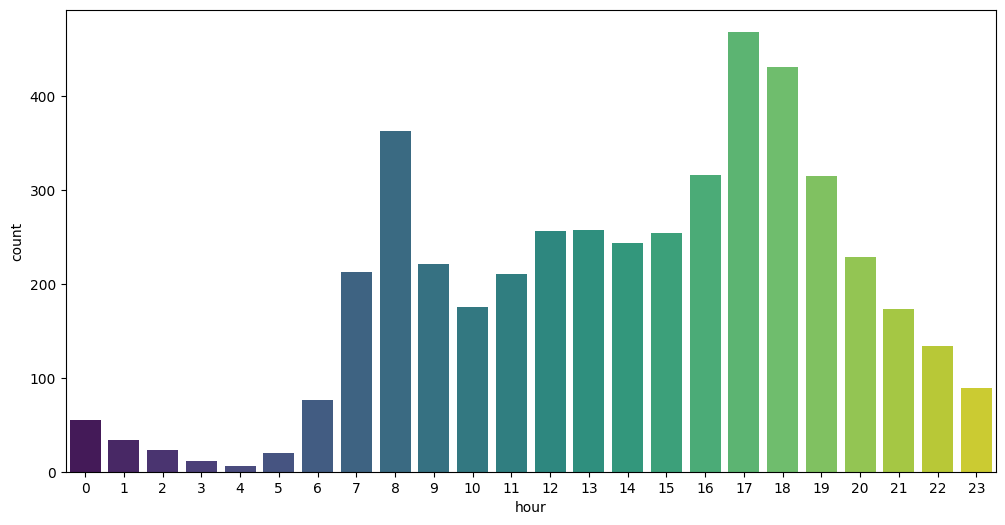

In [33]:
def plot_count_by_category(data, category):
  plt.figure(figsize=(12,6))
  sns.barplot(
      x=category, 
      y='count', 
      data=data.groupby(category)['count'].mean().reset_index(), 
      palette='viridis'
      )
  plt.show()

plot_count_by_category(data, 'hour')

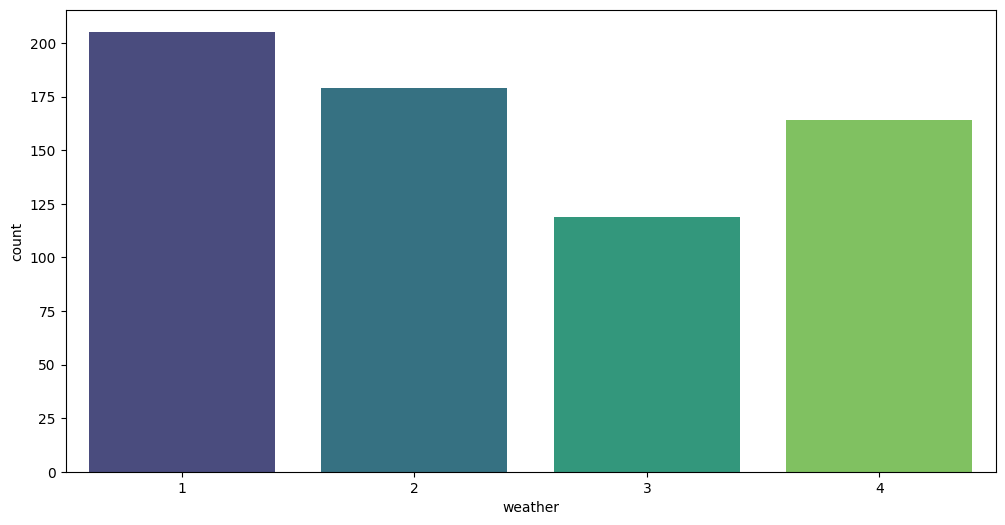

In [34]:
plot_count_by_category(data, 'weather')

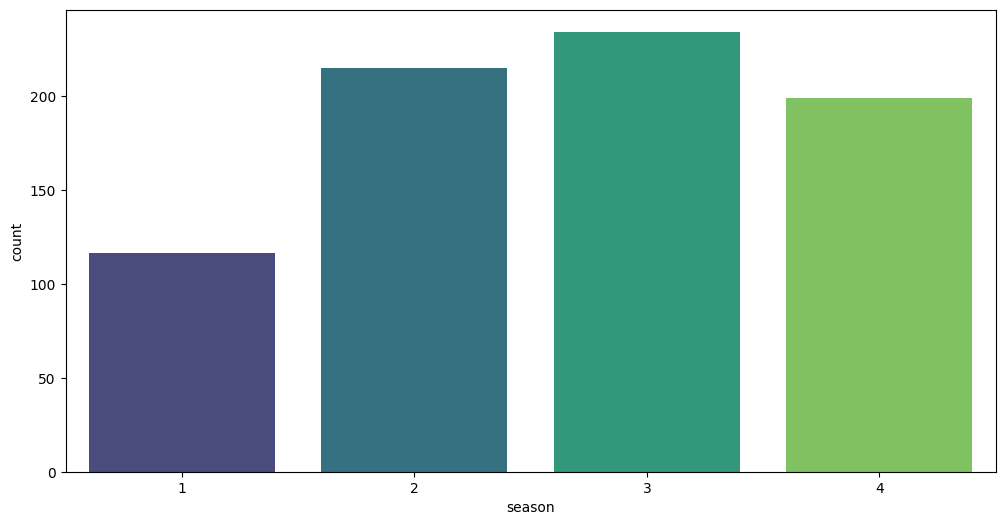

In [35]:
plot_count_by_category(data, 'season')

<ipython-input-68-c0f94ba81e39>:2: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  sns.heatmap(data.corr(), cmap='coolwarm', annot=True, linewidth=.5)


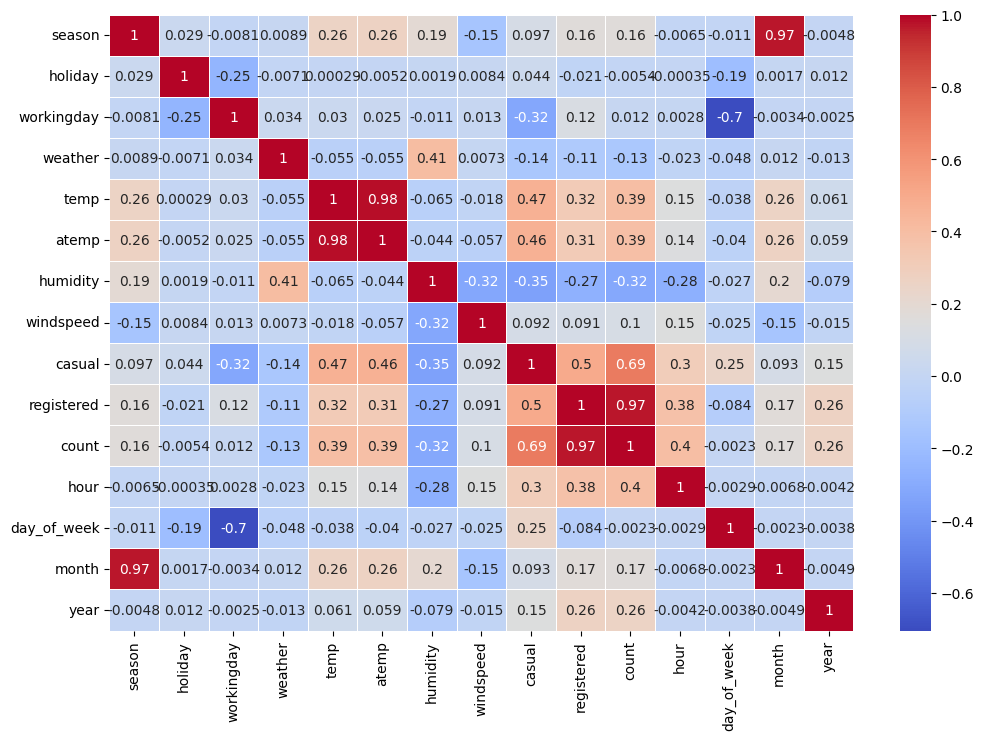

In [68]:
plt.figure(figsize=(12,8))
sns.heatmap(data.corr(), cmap='coolwarm', annot=True, linewidth=.5)
plt.show()

# Feature Engineering

In [84]:
# make a validation split to test our approaches before trying on the actual test set
test_data = data[data['datetime'].dt.day.isin([18, 19])]
train_data = data[~data['datetime'].dt.day.isin([18, 19])]

In [14]:
# What features should we use?

 
 ## Categorical Feature Handling

In [70]:
# What are our categorical features? How should we handle them?
train_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 9749 entries, 0 to 10837
Data columns (total 16 columns):
 #   Column       Non-Null Count  Dtype         
---  ------       --------------  -----         
 0   datetime     9749 non-null   datetime64[ns]
 1   season       9749 non-null   int64         
 2   holiday      9749 non-null   int64         
 3   workingday   9749 non-null   int64         
 4   weather      9749 non-null   int64         
 5   temp         9749 non-null   float64       
 6   atemp        9749 non-null   float64       
 7   humidity     9749 non-null   float64       
 8   windspeed    9749 non-null   float64       
 9   casual       9749 non-null   int64         
 10  registered   9749 non-null   int64         
 11  count        9749 non-null   int64         
 12  hour         9749 non-null   int64         
 13  day_of_week  9749 non-null   int64         
 14  month        9749 non-null   int64         
 15  year         9749 non-null   int64         
dtypes: da

In [71]:
targets = ['casual', 'registered', 'count']
categorical_features = ['season', 'holiday', 'workingday', 'weather', 'hour', 'day_of_week', 'month', 'year']
continuous_features = ['temp', 'atemp', 'humidity', 'windspeed']

In [85]:
encoder = OneHotEncoder(sparse_output=False, drop='first')
encoder.fit(train_data[categorical_features])

OneHotEncoder(drop='first', sparse_output=False)

In [82]:
# test_encoder = OneHotEncoder(sparse_output=False, drop='first')
# test_encoder.fit(test_data[categorical_features])

In [86]:
test_encoded = encoder.transform(test_data[categorical_features])
test_encoded_df = pd.DataFrame(test_encoded, columns=encoder.get_feature_names_out(categorical_features))
test_data = test_data.drop(categorical_features, axis=1).reset_index(drop=True)
test_encoded_df = test_encoded_df.reset_index(drop=True)
test_data = pd.concat([test_data, test_encoded_df], axis=1)

In [87]:
train_encoded = encoder.transform(train_data[categorical_features])
train_encoded_df = pd.DataFrame(train_encoded, columns=encoder.get_feature_names_out(categorical_features))

In [88]:
train_encoded_df

,season_2,season_3,season_4,holiday_1,workingday_1,weather_2,weather_3,weather_4,hour_1,hour_2,...,month_4,month_5,month_6,month_7,month_8,month_9,month_10,month_11,month_12,year_2012
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9744,0.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0
9745,0.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0
9746,0.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0
9747,0.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0


In [89]:
train_data = train_data.drop(categorical_features, axis=1).reset_index(drop=True)


In [90]:
train_encoded_df = train_encoded_df.reset_index(drop=True)


In [91]:
train_data = pd.concat([train_data, train_encoded_df], axis=1)

In [92]:
train_data

,datetime,temp,atemp,humidity,windspeed,casual,registered,count,season_2,season_3,...,month_4,month_5,month_6,month_7,month_8,month_9,month_10,month_11,month_12,year_2012
0,2011-01-01 00:00:00,9.84,14.395,81.0,0.0000,3,13,16,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,2011-01-01 01:00:00,9.02,13.635,80.0,0.0000,8,32,40,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,2011-01-01 02:00:00,9.02,13.635,80.0,0.0000,5,27,32,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,2011-01-01 03:00:00,9.84,14.395,75.0,0.0000,3,10,13,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,2011-01-01 04:00:00,9.84,14.395,75.0,0.0000,0,1,1,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9744,2012-12-17 19:00:00,17.22,21.210,88.0,8.9981,7,333,340,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0
9745,2012-12-17 20:00:00,17.22,21.210,94.0,16.9979,8,192,200,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0
9746,2012-12-17 21:00:00,17.22,21.210,94.0,8.9981,6,114,120,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0
9747,2012-12-17 22:00:00,17.22,21.210,94.0,8.9981,5,49,54,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0


# Model Training

In [99]:
# set up X_train, y_train, X_test, and y_test
X_train = train_data.drop(targets + ['datetime'], axis=1)
y_train = train_data['count']
X_test = test_data.drop(targets + ['datetime'], axis=1)
y_test = test_data['count']

In [100]:
# Train the Linear Regression model
model = LinearRegression()
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

In [19]:
# Evaluate the model

In [108]:
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f'RMSE: {rmse}')
print(f'MAE: {mae}')
print(f'R2: {r2}')

RMSE: 97.9388697141396
MAE: 71.24479141727029
R2: 0.6932806481214957


# Summary